In [124]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import gif
import numpy as np
import pandas as pd
from qutip import *
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings('ignore')
from itertools import product

from scipy.optimize import minimize_scalar
from scipy.signal import argrelextrema

Let's remind ourselves of the Hamiltonian that we've been working with:

$$H =  A \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + \frac{\delta}{2}\left( a^{\dagger} + a \right)\sigma_x$$

A and $\delta$ were chosen because of the path of discovery that we took to get here. From now on it will be convenient for us to re-write the Hamiltonian as:

$$H =  \frac{\Delta E}{2} \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)\sigma_x$$

where we recognise  $\Delta E$ as the difference in energy of our two state system which we will set as $\Delta E = 1$.

In [355]:
delta_E = 1.0  

Last time we saw how this Hamiltonian gave rise to the physics of spontaneous emission when the boson energy matched the two state transition energy, i.e. $\Delta E = \omega$. We will continue to assume that in this tutorial.


In [356]:
omega = delta_E

To explore more, we will relax the assumption we have made up to now of small coupling and instead make the coupling the same as the transition energy

In [382]:
U = delta_E/2

How does such a strongly coupled system behave? Let's see.

We need to choose the maximum number of bosons we want to simulate. We'll start small just keep things simple.

In [383]:
max_bosons = 4

We now need to construct the Hamiltonian using the `tensor` function in the same way as in the previous tutorial.

In [384]:
a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
sx = tensor(qeye(max_bosons+1), sigmax())       # tensorised sigma_x operator
sz = tensor(qeye(max_bosons+1),sigmaz())        # tensorised sigma_z operator

two_state     =  delta_E/2*sz                          # two state system energy
bosons       =  omega*(a.dag()*a+0.5)          # bosons field energy
interaction  = (a.dag() + a) * sx             # interaction energy

H = two_state + bosons + U*interaction

One of the most instructive things to do when you get a new Hamiltonian is to visualise it. QuTiP offers a function called [`hinton`](http://qutip.org/docs/latest/apidoc/functions.html?highlight=hinton#qutip.visualization.hinton) for just such a purpose.

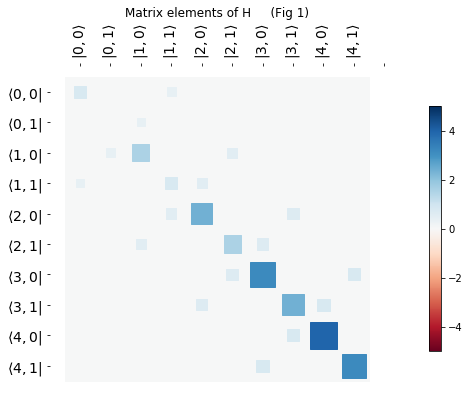

In [385]:
f, ax = hinton(H)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 1)");

The colour and size of the squares in Fig 1 give you a measure of the how large different matrix elements of H are. The off diagonal elements arise solely from the interaction part of the Hamiltonian - this is what allows one state to (in a sense) "mutate" into another.

We'll study Fig 1 in more detail shortly, but for now I want to draw you attention to the labels for the rows and columns. For example, $|3, 0 \rangle$ represents 3 bosons and the two state system in the 0. The two state system numbers are handled somewhat confusingly in QuTiP, namely $0 \rightarrow +$ and $1\rightarrow -$. It will be helpful to have a way to map these QuTiP states to something more immediately recognisable, i.e. $|3, + \rangle$.

In [386]:
possible_ns = range(0, max_bosons+1)
possible_ms = ["+","-"]
nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]

In [387]:
nm_list

[(0, '+'),
 (0, '-'),
 (1, '+'),
 (1, '-'),
 (2, '+'),
 (2, '-'),
 (3, '+'),
 (3, '-'),
 (4, '+'),
 (4, '-')]

We can create some nice labels corresponding to the `nm_list`. This will make things like the hinton plot a lot easier to understand.

In [388]:
bra_labels = ["$\langle$"+str(n)+", "+str(m)+" |" for (n,m) in nm_list]
ket_labels = ["| "+str(n)+", "+str(m)+"$\\rangle$" for (n,m) in nm_list]

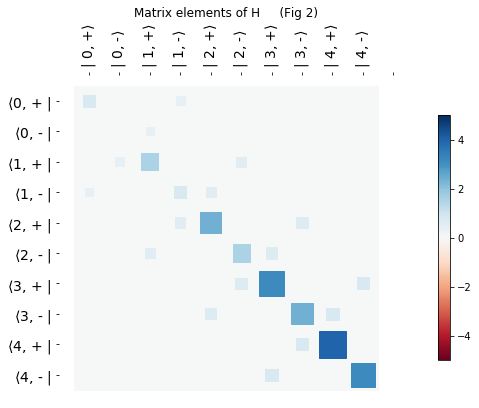

In [389]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 2)");

That's better!

If we take a closer look at the structure of the Hinton diagram we can see some interesting features:

                Matrix elements of H     (Fig 3)


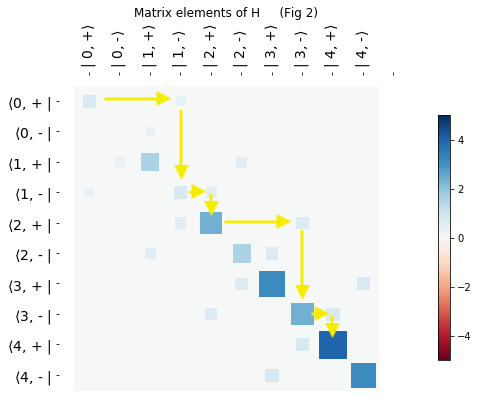

In [390]:
print("                Matrix elements of H     (Fig 3)")
Image(filename='parity.png') 

If we imagine starting a simulation with 0 bosons and the two state system in its + state, i.e. |0,+>, then Fig 3 suggests that:
1. there are connections (albeit indirect) from |0,+> to many different states with many more bosons, e.g. $|0,+> \rightarrow |1,-> \rightarrow |2,+> \rightarrow |3,-> \rightarrow |4,+> ...$. This implies that spontaneous emission of a single boson (as we saw in the last tutorial) isn't the only possibility
2. there are some states that are not accessible at all to the |0,+>

Let's see if these features arise in the simulation and if so what do they mean?

In [401]:
psi0 = tensor(basis(max_bosons+1, 0), basis(2, 0))

In the previous tutorials we have been using QuTiP's [`sesolve`](http://qutip.org/docs/latest/apidoc/functions.html#module-qutip.sesolve) to simulate the system. `sesolve` solves the Schrödinger equation. This was convenient as for us when we were getting started - we only needed a single line of code to run the simulation. It was especially useful when we introduced a time dependent perturbation to our two state Hamiltonian in Tutorial 2. However, `sesolve` will cause us problems as we increase the number of bosons that we want to simulate. 

Technically, we don't actually need a special solver like `sesolve`. When we deal with time-independent problems (like ours), the business of solving the Schrödinger equation can be reduced to a problem of finding the eigenvalues and eigenvectors of the Hamiltonian.

Here's how it works:

1. Transform initial state $\psi_0$ into a new basis defined by the eigenvectors (aka eigenkets) of the Hamiltonian i.e. the states of constant energy (represented here by $|i>$)
  - $\psi_0 = \underset{i}{\Sigma}   <i|\psi_0> |i>$
  -  $<i|\psi_0> = $ `psi0.transform(ekets)[i]`
2. Evolve each part of the state according to its eigenfrequency (aka eigenvalues) $\omega_i$
  - $\psi (t)= \underset{i}{\Sigma}  <i|\psi_0> e^{-i\omega_i t}\ |i>$
  - $\omega_i =$ `evals[i]`
3. Transform the evolved state back into the basis we started with (represented here by $|k>$)
  - $\psi (t)= \underset{i,k}{\Sigma}  <i|\psi_0> e^{-i\omega_i t}\ <k|i>|k>$
  - $<k|i> = $ `ekets[i][k]`

Let's see this in action.

**Step 1**:

In [392]:
evals, ekets = H.eigenstates()
psi0_in_H_basis = psi0.transform(ekets)

In [393]:
psi0_in_H_basis

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[0.        ]
 [0.60845174]
 [0.        ]
 [0.77652691]
 [0.15886692]
 [0.        ]
 [0.        ]
 [0.03932103]
 [0.        ]
 [0.00275667]]

This way of representing $\psi_0$ shows us that $|0,+>$ is mainly a mixture of the 1st and 3rd energy states. QuTiP has a convenient way of visualising the probabilities associated with such a state using [`plot_fock_distribution`](http://qutip.org/docs/latest/apidoc/functions.html?highlight=plot_fock_distribution#qutip.visualization.plot_fock_distribution)

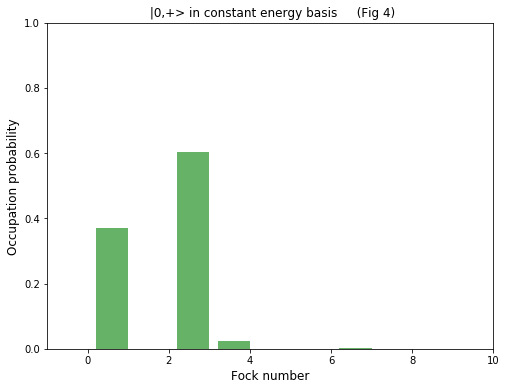

In [402]:
plot_fock_distribution(psi0_in_H_basis, title=f" |0,+> in constant energy basis     (Fig 4)")
plt.xlim(-1,10);

Continuing to follow the procedure, we have:

$\psi_0 = \underset{i}{\Sigma}  <i|\psi_0> |i> \\
\ \ \ \ = 0 |0> + 0.608 |1> + 0 |2> + 0.777 |3> ...$

**Step 2:**

The frequencies are given by the eigenvalues of the Hamiltonian:

In [395]:
evals

array([-0.13328854,  0.38007558,  1.19832028,  1.32648346,  2.12629343,
        2.47485897,  3.32600511,  3.70137098,  5.13410418,  5.46577655])

and so (dropping the zero terms from step 1) the evolved state becomes:

$\psi (t)= \underset{i}{\Sigma}  <i|\psi_0> e^{-i\omega_i t}\ |i> \\
\ \ \ \ =  0.608 e^{-i 0.380t}|1> + 0.777 e^{-i 1.326t} |3> ...$

**Step 3:**

Taking only the $|1>$ part form part 2 above for the sake of brevity, we only need to look at `ekets[1]`

In [396]:
ekets[1]

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[ 0.60845174]
 [ 0.        ]
 [ 0.        ]
 [-0.75438818]
 [ 0.23113593]
 [ 0.        ]
 [ 0.        ]
 [-0.08328356]
 [ 0.01802704]
 [ 0.        ]]

Then:

$0.608 e^{-i 0.380t}|1> \rightarrow 0.608 e^{-i 0.380t}0.608|0'> + 0.608 e^{-i 0.380t}(-0.754)|3'> + 0.608 e^{-i 0.380t}0.231|4'> ...$

where the prime in $|n'>$ indicates the original basis and not the energy basis. We can relabel these states to be the more familiar $|n,\pm>$ using the list we made earlier:

In [397]:
nm_list

[(0, '+'),
 (0, '-'),
 (1, '+'),
 (1, '-'),
 (2, '+'),
 (2, '-'),
 (3, '+'),
 (3, '-'),
 (4, '+'),
 (4, '-')]

From this we see that:

$|0'> = |0,+>$,  

$|3'> = |1,->$ 

$|4'> = |2,+>$

and so we have:

$0.608 e^{-i 0.380t}|1> \rightarrow 0.608 e^{-i 0.380t}0.608|0,+> + 0.608 e^{-i 0.380t}(-0.754)|1,-> + 0.608 e^{-i 0.380t}0.231|2,+> ...$

All of the above can be automated by making a function that we can reuse again and again:

In [438]:
T = np.zeros([max_bosons+1)*2,times.size])

In [445]:
times.size

100

In [447]:
T

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.],
       [ 0.,  6.,  0.,  0.,  0.],
       [ 0.,  7.,  0.,  0.,  0.],
       [ 0.,  8.,  0.,  0.,  0.],
       [ 0.,  9.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  0.]])

In [446]:
T[:,1] = np.array([1,2,3,4,5,6,7,8,9,10])

In [503]:
def simulate(H, psi0, times):
    evals, ekets = H.eigenstates()
    psi0_in_H_basis = psi0.transform(ekets)
    A = np.zeros([(max_bosons+1)*2,times.size], dtype="complex128")
    P = np.zeros([(max_bosons+1)*2,times.size], dtype="complex128")
    for k in range(0,(max_bosons+1)*2):
        amp = 0
        for i in range(0,(max_bosons+1)*2):
            amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
        A[k,:] = amp
        P[k,:] = amp*np.conj(amp)
    return P, A

In [504]:
times = np.linspace(0.0, 14.0, 100)
P, A = simulate(H, psi0, times)

In [505]:
shape(P)

(10, 100)

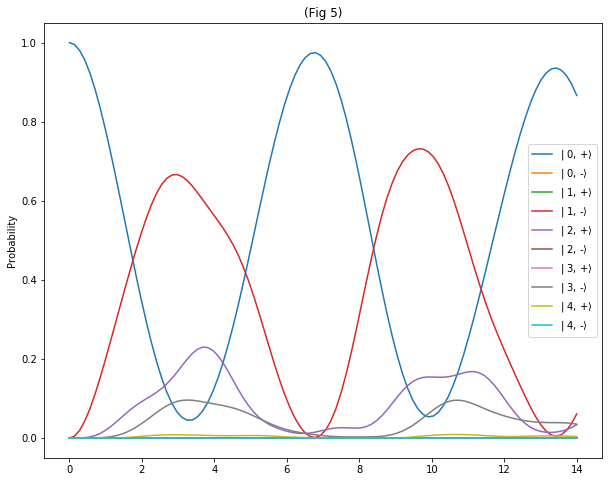

In [520]:
plt.figure(figsize=(10,8))
for i in range(0,(max_bosons+1)*2):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.legend(loc="right")
plt.title("(Fig 5)")
plt.show();

Fig 5 is the equivalent of Fig 2 from the previous tutorial - the only significant difference is the coupling is now much larger. 

Whereas previously we saw only the Rabi oscillation between $|0,+>$ and $|1,->$, now we see much more. There is a non negligible probability of finding the system with 2 or even 3 bosons - as was suggested in the Hinton diagram.

But, how is such a things possible? Doesn't it violate conservation of energy? After all, 2 bosons have more energy than the + state we started in. 

As you might suspect, the answer is no, energy is conserved, the "missing" energy comes from the interaction term in the Hamiltonian.

In [507]:
H

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[1.         0.         0.         0.5        0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.5        0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.5        2.         0.         0.         0.70710678
  0.         0.         0.         0.        ]
 [0.5        0.         0.         1.         0.70710678 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.70710678 3.         0.
  0.         0.8660254  0.         0.        ]
 [0.         0.         0.70710678 0.         0.         2.
  0.8660254  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.8660254
  4.         0.         0.         1.        ]
 [0.         0.         0.         0.         0.8660254  0.
  0.         3.         1.         0.        ]
 [0.         0.         0.     

In [508]:
expect(H,Qobj(A[:,20],dims=[[5,2],[1,1]]))

1.0

In [509]:
A[:,20]

array([-0.29453775+0.02789718j,  0.        +0.j        ,
        0.        +0.j        , -0.49055372+0.65165024j,
        0.32154774-0.21794382j,  0.        +0.j        ,
        0.        +0.j        , -0.27369004+0.11468793j,
        0.08375276-0.03480995j,  0.        +0.j        ])

In [510]:
all(P[3]==0)

False

In [511]:
Qobj(A[:,2],dims=[[5,2],[1,1]])

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[ 9.50714735e-01-2.76299608e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-3.89509088e-02-1.34495341e-01j]
 [-1.23693306e-02+6.28944873e-03j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 6.06892853e-04+9.57938938e-04j]
 [ 5.92667633e-05-5.35673036e-05j]
 [ 0.00000000e+00+0.00000000e+00j]]

In [512]:
A[:,20]

array([-0.29453775+0.02789718j,  0.        +0.j        ,
        0.        +0.j        , -0.49055372+0.65165024j,
        0.32154774-0.21794382j,  0.        +0.j        ,
        0.        +0.j        , -0.27369004+0.11468793j,
        0.08375276-0.03480995j,  0.        +0.j        ])

In [517]:
H.dims

[[5, 2], [5, 2]]

In [518]:
AA = []
for i, t in enumerate(times):
    AA.append(expect(interaction,Qobj(A[:,i],dims=[[5,2],[1,1]])))

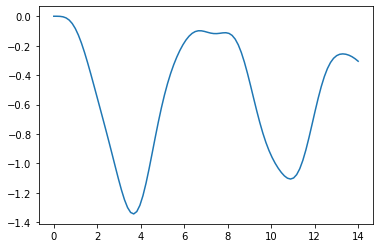

In [524]:
plt.plot(times,AA)

In [477]:
def states_to_df(states,times):
    data = {}
    for i in range(0,states[0].shape[0]):
        which_mode = divmod(i,2)
        if which_mode[1] == 0:
            two_state = "+"
        elif which_mode[1] == 1:
            two_state = "-"
        data[str(which_mode[0])+" , "+two_state] = np.zeros(len(times),dtype="complex128")
    
    for i, state in enumerate(states):
        for j, psi in enumerate(state):
            which_mode = divmod(j,2)
            if which_mode[1] == 0:
                two_state = "+"
            elif which_mode[1] == 1:
                two_state = "-"
            data[str(which_mode[0])+" , "+two_state][i] = psi[0][0]

    return pd.DataFrame(data=data, index=times)

In [515]:
A[:,5]

array([ 0.71393172-0.61045979j,  0.        +0.j        ,
        0.        +0.j        , -0.21310637-0.25646651j,
       -0.03117895+0.07217938j,  0.        +0.j        ,
        0.        +0.j        ,  0.01592575+0.00275105j,
       -0.00071791-0.00269017j,  0.        +0.j        ])

In [516]:
result.states[5]

Quantum object: dims = [[5, 2], [1, 1]], shape = (10, 1), type = ket
Qobj data =
[[ 0.71393182-0.6104597j ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.21310652-0.25646635j]
 [-0.03117886+0.07217939j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.01592572+0.00275099j]
 [-0.00071793-0.00269012j]
 [ 0.        +0.j        ]]

In [478]:
psi0 = tensor(basis(max_bosons+1, 0), basis(2, 0))  # No bosons and two-state system is in the higher energy + state

times = np.linspace(0.0, 14.0, 100)      # simulation time

result = sesolve(H, psi0, times)
df_coupled =  states_to_df(result.states, times)

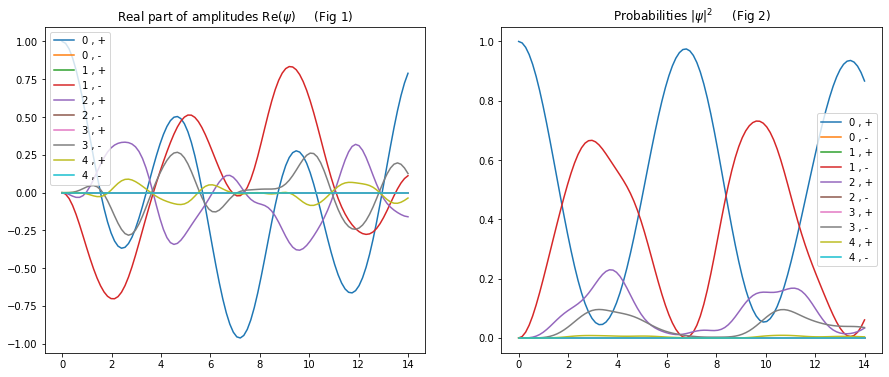

In [479]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df_coupled.plot(title="Real part of amplitudes Re($\psi$)     (Fig 1)", ax=axes[0]);
(df_coupled.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 2)", ax=axes[1]);

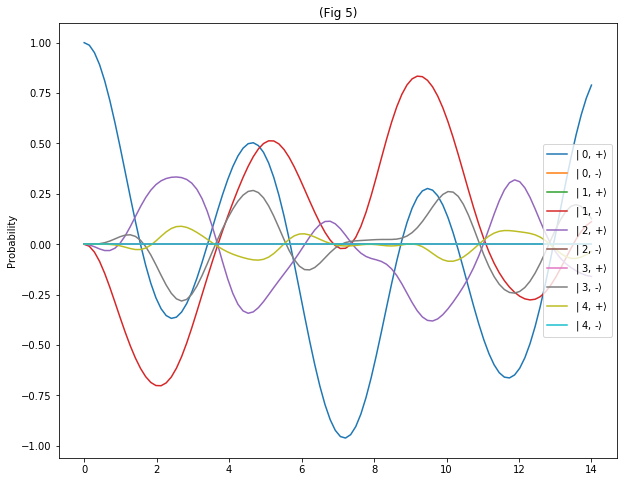

In [480]:
plt.figure(figsize=(10,8))
for i in range(0,(max_bosons+1)*2):
    plt.plot(times, A[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.legend(loc="right")
plt.title("(Fig 5)")
plt.show();

In [33]:
P = sz*(1j*np.pi*a.dag()*a).expm()

In [38]:
(1j*np.pi*a.dag()*a).expm()

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]

In [37]:
P

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]]

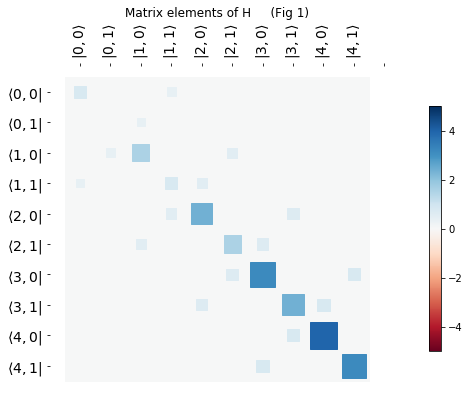

In [35]:
f, ax = hinton(H)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 1)");

In [31]:
commutator(H,P)

Quantum object: dims = [[5, 2], [5, 2]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

In [95]:
possible_ms

array([ 0.5, -0.5])

In [58]:
psi0 = tensor(basis(max_bosons+1, 0), basis(2, 0))

In [59]:
evals, ekets = H.eigenstates()
psi0_in_H_basis = psi0.transform(ekets)

In [60]:
times = np.linspace(0.0, 14.0, 100)

In [61]:
P = []

for k in range(0,(max_bosons+1)*2):
    amp = 0
    for i in range(0,max_bosons+1):
        amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
    P.append(amp*np.conj(amp))

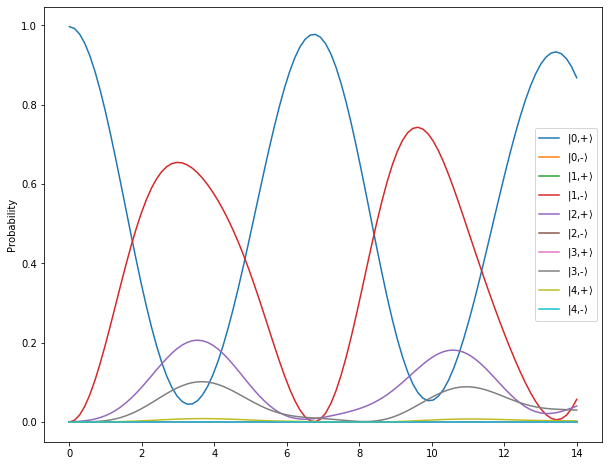

In [119]:
plt.figure(figsize=(10,8))
for i in range(0,(max_bosons+1)*2):
    plt.plot(times, P[i], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.legend(loc="right")
plt.show();

In [75]:
ket_labels

[]

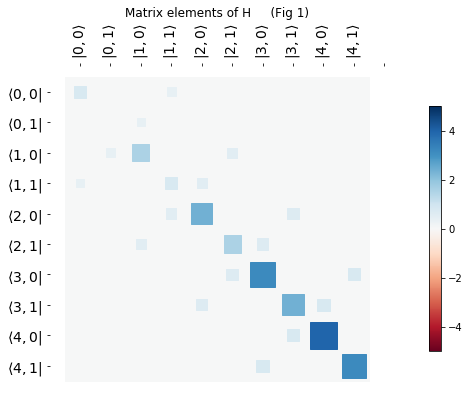

In [11]:
f, ax = hinton(H)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 1)");

In [15]:
evals, ekets = H.eigenstates()

In [16]:
evals

array([-5.00012500e-05,  9.89950123e-01,  1.00994987e+00,  1.98580821e+00,
        2.01409178e+00,  2.98263015e+00,  3.01726986e+00,  3.98007562e+00,
        4.02007440e+00,  5.00019999e+00])

## Calculate energy eigenvalues for different couplings

In [208]:
delta_E = 1.0            # two level energy difference
N = 2                    # number of phonon quanta needed to exite the atom
omega = delta_E / N          # phonon energy
max_bosons =  100             # Max mode number to simulation
num_U = 100                  # number of different coupling strengths to try out (need 100 to reproduce SJByrnes Moiré pattern)
U_min = 0.01    # min atom phonon coupling
U_max = 0.8*delta_E     # maximum atom phonon coupling

In [209]:
a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
sx = tensor(qeye(max_bosons+1), sigmax())             # tensorised sigma_x operator
sz = tensor(qeye(max_bosons+1),sigmaz())              # tensorised sigma_z operator

two_state     =  delta_E/2*sz                          # two state system energy
bosons       =  omega*(a.dag()*a+0.5)          # bosons field energy
interaction   = (a.dag() + a) * sx     # interaction energy (needs to be multiplied by coupling constant)

number           = a.dag()*a  # phonon number operator
spin          = sz/2       # z component of spin

In [210]:
H = two_state + bosons + interaction

In [211]:
# f, ax = hinton(H)
# ax.tick_params(axis='x',labelrotation=90)
# ax.set_title("Matrix elements of H     (Fig 1)");

In [212]:
parity = "even"

In [213]:
#inspired by SJB code https://github.com/sbyrnes321/cf/blob/1a34a461c3b15e26cad3a15de3402142b07422d9/spinboson.py#L56
if parity != "all":
    S=1/2
    possible_ns = range(0, max_bosons+1)
    possible_ms = - (np.arange(2*S+1) - S)
    Smn_list = product([S], possible_ns, possible_ms)

    if parity == "even":
        mn_from_index = [(n,int(np.abs(m-0.5))) for (S,n,m) in Smn_list if (S+m+n) % 2 == 0]
    elif parity == "odd":
        mn_from_index = [(n,int(np.abs(m-0.5))) for (S,n,m) in Smn_list if (S+m+n) % 2 == 1]

    subset_idx = []
    for s in mn_from_index:
        subset_idx.append(state_number_index([max_bosons+1,2],s))
    
    # Labels for hinton plots in case we want to plot it later (use xlabels=ket_labels, ylabels = bra_labels)
    bra_labels = ["$\langle$"+str(n)+", "+str(m)+"|" for (n,m) in mn_from_index]
    ket_labels = ["|"+str(n)+", "+str(m)+"$\\rangle$" for (n,m) in mn_from_index]


It will be helpful for us to be able to search for the index of a particular state by the (n,m) numbers

In [214]:
def index_from_nm(n,m): 
    try:
        return [item for item in mn_from_index].index((n,m))
    except:
        print("ERROR: State doesn't exist or has the wrong parity ")

In [215]:
    # http://qutip.org/docs/latest/apidoc/classes.html?highlight=extract_states#qutip.Qobj.extract_states
    two_state    = two_state.extract_states(subset_idx) 
    bosons      = bosons.extract_states(subset_idx) 
    interaction  = interaction.extract_states(subset_idx) 
    number          = (a.dag()*a).extract_states(subset_idx)
    spin         = spin.extract_states(subset_idx)

In [216]:
# H = two_state + bosons + interaction
# f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
# ax.tick_params(axis='x',labelrotation=90)
# ax.set_title("Matrix elements of H     (Fig 1) EVEN");

In [217]:
d = {"coupling":np.linspace(U_min,U_max,num_U)}
for i in range((max_bosons+1)):
    d[f"level_{i}"] = np.zeros(num_U)
    
df = pd.DataFrame(data=d)


# We'll create some dataframes to store expectation values for: 
df_num = pd.DataFrame(data=d) # phonon number
df_sz = pd.DataFrame(data=d)  # z component of spin
df_int = pd.DataFrame(data=d) # interaction energy

In [218]:
for index, row in df.iterrows():
    # c.f. https://coldfusionblog.net/2017/07/09/numerical-spin-boson-model-part-1/
    H = two_state + bosons + row.coupling*interaction
    evals, ekets = H.eigenstates()
    df.iloc[index,1:] = np.real(evals/omega)
    
    # We'll also calculate some expectation values so we don't have to do it later
    df_num.iloc[index,1:] = expect(number,ekets)           # phonon number
    df_sz.iloc[index,1:] = expect(spin,ekets)           # z component of spin
    df_int.iloc[index,1:] = expect(row.coupling*interaction,ekets)   # interaction energy

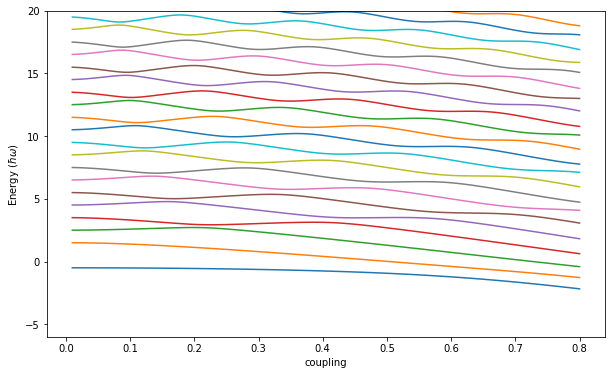

In [219]:
df.plot(x="coupling",ylim=[-6,20],figsize=(10,6),legend=False);
plt.ylabel("Energy ($\hbar\omega$)");

## More detail on energy levels 7 and 8

In [224]:
level_number_1 = 2
level_number_2 = 3

In [225]:
level_label_1 = f"level_{level_number_1}"
level_label_2 = f"level_{level_number_2}"

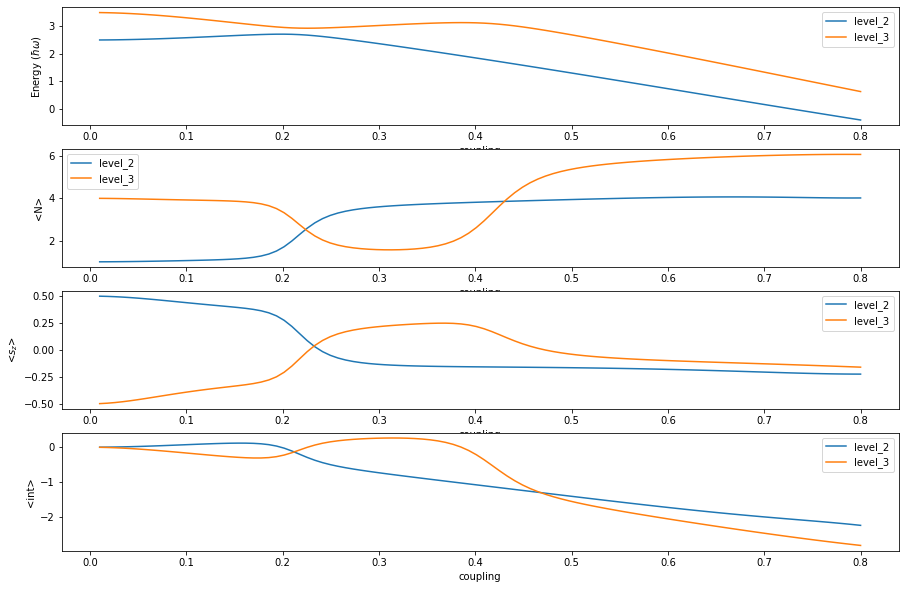

In [226]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,10))
df[["coupling",level_label_1,level_label_2]].plot(x="coupling",ax=axes[0]);
df_num[["coupling",level_label_1,level_label_2]].plot(x="coupling",ax=axes[1]);
df_sz[["coupling",level_label_1,level_label_2]].plot(x="coupling",ax=axes[2]);
df_int[["coupling",level_label_1,level_label_2]].plot(x="coupling",ax=axes[3]);
axes[0].set_ylabel("Energy ($\hbar\omega$)")
axes[1].set_ylabel("<N>")
axes[2].set_ylabel("<$s_z$>");
axes[3].set_ylabel("<int>");

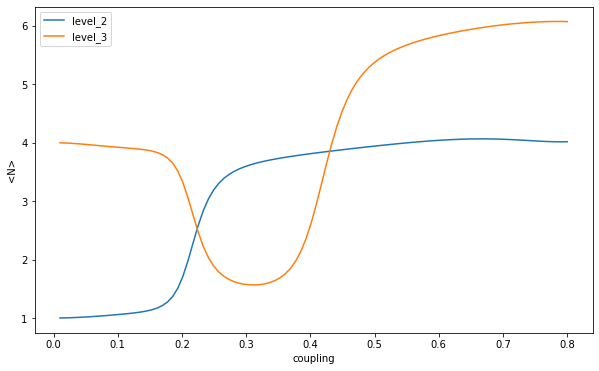

In [227]:
df_num[["coupling",level_label_1,level_label_2]].plot(x="coupling",figsize=(10,6));
plt.ylabel("<N>");

## Find the anti-crossing points

### Start with rough calculation of the anti-crossing coupling

In [228]:
df_diff = df.drop('coupling', axis=1).diff(axis=1).dropna(axis=1)
df_diff["coupling"] = df["coupling"]

In [229]:
level_label = level_label_2

df_diff_subset = df_diff[["coupling",level_label]]
df_diff_subset["min"] =  df_diff_subset[[level_label]].min(axis=1)
df_diff_subset["level_min"] = df_diff_subset[[level_label]].idxmin(axis=1).str.split("_",expand = True)[1]

argmin = argrelextrema(df_diff_subset["min"].values, np.less)[0]
anti_crossing = df_diff_subset.iloc[argmin][["coupling","min","level_min"]]
anti_crossing.reset_index(inplace=True,drop=True)

In [230]:
anti_crossing

,coupling,min,level_min
0,0.209495,0.233773,3


### Now more precise calculation of anti-crossing couplings

In [231]:
# Define a function which returns the energy difference between two levels for a given coupling
def ev(U,i):
    H = two_state + bosons + U*interaction
    evals, ekets = H.eigenstates()
    return evals[i] - evals[i-1] 

In [232]:
dU = (U_max - U_min)/num_U

In [233]:
for index, row in anti_crossing.iterrows():
    res = minimize_scalar(ev,args=int(row["level_min"]),bracket=[row["coupling"]-dU, row["coupling"]+dU])
    anti_crossing.loc[index, "coupling"] = res.x
    anti_crossing.loc[index, "min"] = res.fun

In [234]:
anti_crossing

,coupling,min,level_min
0,0.211934,0.11659,3


## Simulation of the first anti-crossing

### First let's look at some expectation values at the anti-crossing

In [235]:
H = two_state + bosons + anti_crossing.loc[0]["coupling"]*interaction
# H = two_state + bosons + 0.15*interaction
# H = two_state + bosons + 0.531938*interaction # for N=1
# H = two_state + bosons + 0.08103160077219432*interaction # for N=11
evals, ekets = H.eigenstates()

In [236]:
print("state", "energy", "number", "spin")
for i in range(level_number_1-3,level_number_2+3):
    print(i, evals[i]/omega, expect(number,ekets[i]), expect(spin,ekets[i]))

state energy number spin
-1 106.26853785299124 98.56128153769299 0.06483392176941205
0 -0.5624193580614852 0.025321800904233745 -0.4787725126047104
1 1.0896370918203657 1.916117640272339 -0.32807283111615027
2 2.703986773518986 2.0749194009847955 0.19917314837391586
3 2.937166636128328 2.9664966239141397 -0.13002546389608485
4 4.590278821998608 5.436922488762485 -0.12180307700868674
5 5.094454911504115 3.6360500775342692 0.16749705090302527


We see above that levels 7 and 8 are almost identical which confirms what we see in the figures above

### What are the anti-crossing eigenstates made of?

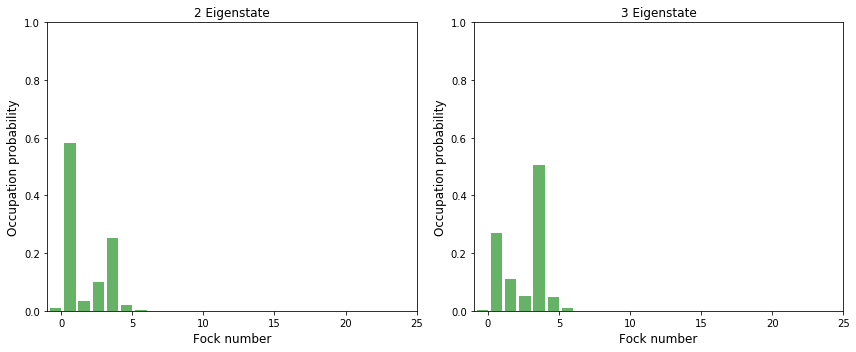

In [237]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
plot_fock_distribution(ekets[level_number_1], title=f"{level_number_1} Eigenstate", ax=axes[0])
plot_fock_distribution(ekets[level_number_2],title=f"{level_number_2} Eigenstate", ax=axes[1])
axes[0].set_xlim(-1,25)
axes[1].set_xlim(-1,25)
fig.tight_layout()

The Energy eigenstates that come together at the anti-crossing are mostly made up of states numbered:

In [238]:
P_eigenstate = ekets[level_number_1].full()*np.conj(ekets[level_number_1].full())
P_eigenstate = np.hstack(P_eigenstate)
eigenstate_composition = P_eigenstate.argsort()[-2:][::-1]
print(eigenstate_composition[0], ",", eigenstate_composition[1])

1 , 4


What do these numbered states corresponds to? We can use the `mn_from_index` to find the n and m numbers.

In [239]:
print ( mn_from_index[eigenstate_composition[0]], ",", mn_from_index[eigenstate_composition[1]])

(1, 0) , (4, 1)


### What does the most dominate part look like in basis of the eigenstates?

We should create the state by using `tensor` function and the extracting the states that have the wrong parity. We can however create the state directly from the `basis` function using the index we found above.

In [240]:
i0 = eigenstate_composition[0]

In [241]:
psi0 = basis(max_bosons+1, i0)

In [242]:
psi0_in_H_basis = psi0.transform(ekets)

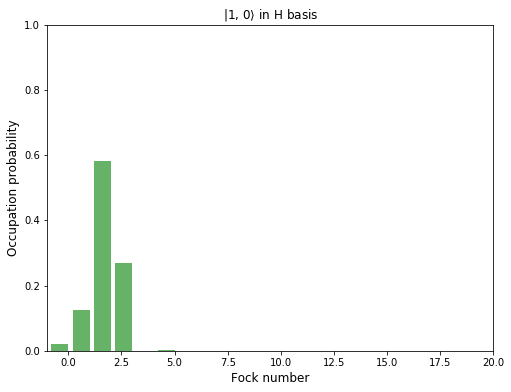

In [243]:
plot_fock_distribution(psi0_in_H_basis, title=f"{ket_labels[i0]} in H basis")
plt.xlim(-1,20);

so |1,0> (ie 1 bosons and lower state for two state system) is mixture of eigenstates 7 and 8.

Therefore if we start the system off in |1,0> we can expect it to rabi oscillate between 7 and 8 which should give us some oscilation between |1,0> and |14,1>. 

Let's see

In [244]:
P = []

for i in range(0,max_bosons+1):
    psi = basis(max_bosons+1,i)
    P.append(psi*psi.dag())

In [245]:
times = np.linspace(0.0, 1000.0, 10000)      # simulation time

result = sesolve(H, psi0, times,P)

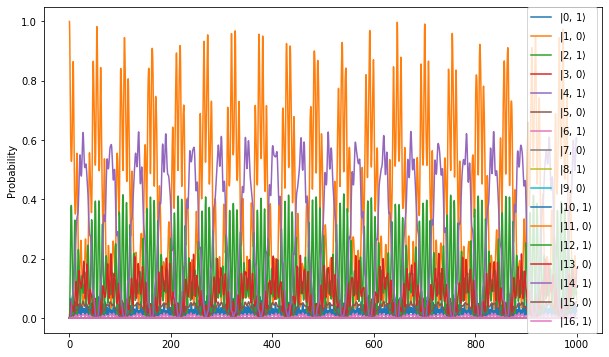

In [246]:
plt.figure(figsize=(10,6))
for i in range(0,17):
    plt.plot(times, result.expect[i], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.legend(loc="right")
plt.show();



Not much osccilation at all!

Maybe we need to wait longer. Let's manually do a time varying state otherwise it will take a very long time.

> TODO: explain the method below

In [250]:
times = np.linspace(0.0, 1000000.0, 10000)

In [251]:
P = []

for k in range(0,max_bosons+1):
    amp = 0
    for i in range(0,max_bosons+1):
        amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
    P.append(amp*np.conj(amp))

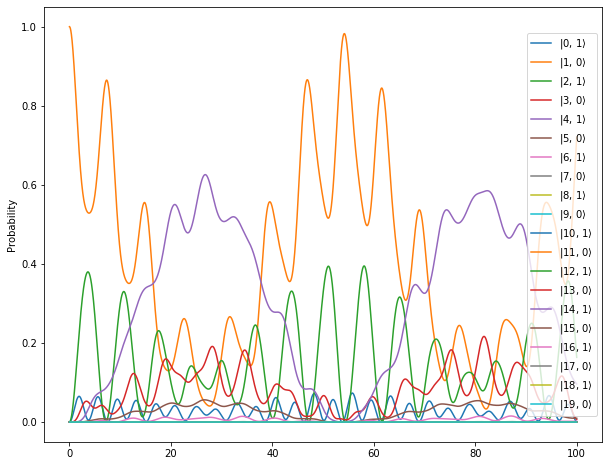

In [252]:
plt.figure(figsize=(10,8))
for i in range(0,20):
    plt.plot(times, P[i], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.legend(loc="right")
plt.show();

Seems like we'd have to wait a really long time to see the Rabi oscillation.

### How sensitive is the anti-crossing?

In [480]:

# Us = np.linspace(anti_crossing.loc[0]["coupling"]/10,2*anti_crossing.loc[0]["coupling"],40)

Us_min = anti_crossing.loc[0]["coupling"] - anti_crossing.loc[0]["coupling"]/5000
Us_max = anti_crossing.loc[0]["coupling"] + anti_crossing.loc[0]["coupling"]/5000
Us = np.linspace(Us_min,Us_max,21)
Ps = []
for U in Us:
    H = two_state + bosons + U*interaction
    evals, ekets = H.eigenstates()
    times = np.linspace(0.0, 1000000.0, 10000)

    psi0 = basis(max_bosons+1, i0)
    psi0_in_H_basis = psi0.transform(ekets)

    P = []

    for k in range(0,max_bosons+1):
        amp = 0
        for i in range(0,max_bosons+1):
            amp +=  psi0_in_H_basis[i][0][0]*np.exp(-1j*evals[i]*times)*ekets[i][k][0][0]
        P.append(amp*np.conj(amp))
    Ps.append(P)

In [481]:
psi0_level = []
for U in Us:
    H = two_state + bosons + U*interaction
    evals, ekets = H.eigenstates()
    psi0_in_H_basis = psi0.transform(ekets)
    P0 = psi0_in_H_basis.full()*np.conj(psi0_in_H_basis.full())
    P0 = np.hstack(P0)
    psi0_level.append(P0.argmax())

In [482]:
@gif.frame
def plot(P,j):
    plt.figure(figsize=(10,8))
    for i in range(0,20):
        plt.plot(times, P[i], label=f"{ket_labels[i]}")
    plt.ylabel("Probability")
    plt.xlabel("Time")
    plt.legend(loc="right")
    plt.title(f"U = {Us[j]}")

In [489]:
@gif.frame
def plot2(P,j):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    for i in range(0,20):
        axes[0].plot(times, P[i], label=f"{ket_labels[i]}")
    axes[0].set_ylabel("Probability")
    axes[0].set_xlabel("Time")
    axes[0].legend(loc="right")
    deltaU = (Us[j]-anti_crossing.loc[0]["coupling"])/anti_crossing.loc[0]["coupling"]*100
    axes[0].set_title(f"$\Delta U / U_{{anti\\times}}$ = {deltaU:.3f}%")
    df.plot(x="coupling",ylim=[-6,20],legend=False,ax=axes[1], title=f"Tracking energy level of {ket_labels[i0]} state");
    axes[1].set_ylabel("Energy ($\hbar\omega$)");
    axes[1].plot(Us[j],np.interp(Us[j],df["coupling"], df[f"level_{psi0_level[j]}"]),"ok")

In [490]:
frames = []
for j, P in enumerate(Ps):
    frame = plot2(P, j)
    frames.append(frame)
gif.save(frames, "anti-crossing-approach.gif", duration=500)

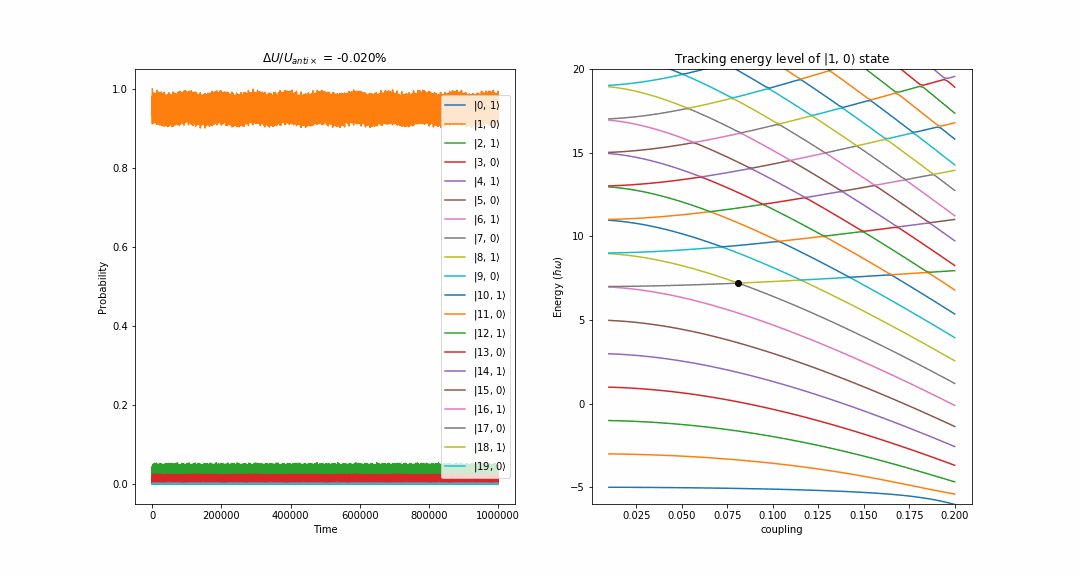

In [491]:
Image(filename="./anti-crossing-approach.gif")

In [ ]:
def index_from_nm(n,m): 
    try:
        return [item for item in nm_list].index((n,m))
    except:
        print("ERROR: State doesn't exist")